In [ ]:
import os
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


IMAGE_SIZE = (64, 64)
BATCH_SIZE = 32
EPOCHS = 20

ORIGINAL_TRAIN_PATH = "/dataset/Train"
ORIGINAL_TEST_PATH = "/dataset/Test"
BINARY_TRAIN_PATH = "/dataset_binary/Train"
BINARY_TEST_PATH = "/dataset_binary/Test"

In [ ]:
def restructure_dataset(source_path: str, target_path: str) -> None:
    if not os.path.exists(target_path):
        os.makedirs(target_path)

    fresh_path = os.path.join(target_path, "Fresh")
    rotten_path = os.path.join(target_path, "Rotten")
    os.makedirs(fresh_path, exist_ok=True)
    os.makedirs(rotten_path, exist_ok=True)

    for class_name in os.listdir(source_path):
        class_path = os.path.join(source_path, class_name)

        if not os.path.isdir(class_path):
            continue

        if class_name.lower().startswith("fresh"):
            destination = fresh_path

        elif class_name.lower().startswith("rotten"):
            destination = rotten_path

        else:
            print(f"Unknown class name: {class_name}")
            continue

        for filename in os.listdir(class_path):
            src_file = os.path.join(class_path, filename)
            dst_file = os.path.join(destination, f"{class_name}_{filename}")
            shutil.copy2(src_file, dst_file)

        print(f"'{class_name}' -> '{os.path.basename(destination)}'")


restructure_dataset(ORIGINAL_TRAIN_PATH, BINARY_TRAIN_PATH)
restructure_dataset(ORIGINAL_TEST_PATH, BINARY_TEST_PATH)

'freshtomato' -> 'Fresh'
'rottenokra' -> 'Rotten'
'rottenapples' -> 'Rotten'
'rottentomato' -> 'Rotten'
'rottencucumber' -> 'Rotten'
'freshoranges' -> 'Fresh'
'freshcapsicum' -> 'Fresh'
'freshpotato' -> 'Fresh'
'rottenpotato' -> 'Rotten'
'rottencapsicum' -> 'Rotten'
'freshbanana' -> 'Fresh'
'freshbittergroud' -> 'Fresh'
'freshokra' -> 'Fresh'
'rottenoranges' -> 'Rotten'
'rottenbittergroud' -> 'Rotten'
'freshapples' -> 'Fresh'
'freshcucumber' -> 'Fresh'
'rottenbanana' -> 'Rotten'
'rottenokra' -> 'Rotten'
'rottenapples' -> 'Rotten'
'rottencucumber' -> 'Rotten'
'freshoranges' -> 'Fresh'
'freshbanana' -> 'Fresh'
'freshokra' -> 'Fresh'
'rottenoranges' -> 'Rotten'
'rottentamto' -> 'Rotten'
'rottenpatato' -> 'Rotten'
'freshtamto' -> 'Fresh'
'freshpatato' -> 'Fresh'
'freshapples' -> 'Fresh'
'freshcucumber' -> 'Fresh'
'rottenbanana' -> 'Rotten'


In [4]:
train_val_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_val_gen.flow_from_directory(
    BINARY_TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_data = train_val_gen.flow_from_directory(
    BINARY_TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

test_data = test_gen.flow_from_directory(
    BINARY_TEST_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 18896 images belonging to 2 classes.
Found 4723 images belonging to 2 classes.
Found 6738 images belonging to 2 classes.


In [6]:
inputs = Input(shape=(64, 64, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,418,337 (9.23 MB)

 Trainable params: 2,417,889 (9.22 MB)

 Non-trainable params: 448 (1.75 KB)

In [7]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(patience=3, monitor="val_loss", restore_best_weights=True),
    ],
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 146s 227ms/step - accuracy: 0.6687 - loss: 0.8741 - val_accuracy: 0.7650 - val_loss: 0.5289
Epoch 2/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 99s 167ms/step - accuracy: 0.7810 - loss: 0.4445 - val_accuracy: 0.5062 - val_loss: 0.6387
Epoch 3/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 141s 166ms/step - accuracy: 0.8170 - loss: 0.3872 - val_accuracy: 0.7993 - val_loss: 0.4810
Epoch 4/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 98s 166ms/step - accuracy: 0.8559 - loss: 0.3273 - val_accuracy: 0.7811 - val_loss: 0.5297
Epoch 5/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 97s 165ms/step - accuracy: 0.8668 - loss: 0.3038 - val_accuracy: 0.7015 - val_loss: 0.7077
Epoch 6/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 97s 164ms/step - accuracy: 0.8899 - loss: 0.2712 - val_accuracy: 0.7870 - val_loss: 0.4754
Epoch 7/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 98s 165ms/step - accuracy: 0.9007 - loss: 0.2502 - val_accuracy: 0.8196 - val_loss: 0.4844
Epoch 8/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 97s 164ms/step - accuracy: 0.9163 - loss:

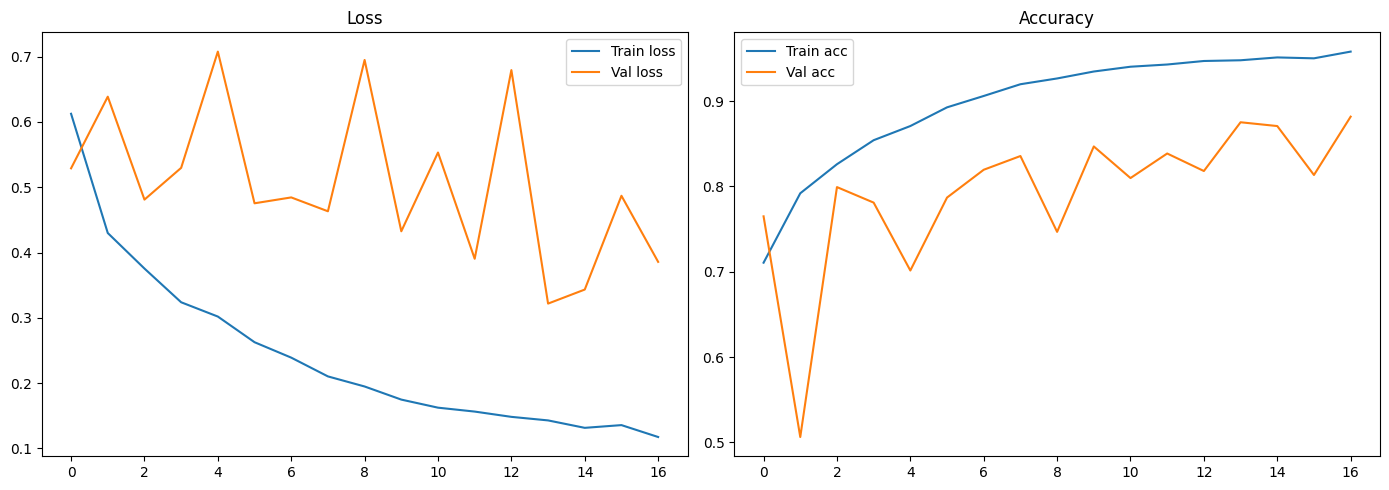

In [8]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train acc")
plt.plot(history.history["val_accuracy"], label="Val acc")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
test_data.reset()
y_true = test_data.classes
y_pred_proba = model.predict(test_data, steps=len(test_data), verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

pd.DataFrame(
    {
        "y_true": y_true,
        "y_pred": y_pred,
        "is_correct": y_true == y_pred
    }
).head(10)

,y_true,y_pred,is_correct
0,0,0,True
1,0,0,True
2,0,1,False
3,0,0,True
4,0,0,True
5,0,0,True
6,0,0,True
7,0,0,True
8,0,0,True
9,0,0,True


In [10]:
print("Classification report")
print(classification_report(y_true, y_pred, target_names=["Fresh", "Rotten"]))

Classification report
              precision    recall  f1-score   support

       Fresh       0.92      0.91      0.91      3245
      Rotten       0.92      0.92      0.92      3493

    accuracy                           0.92      6738
   macro avg       0.92      0.92      0.92      6738
weighted avg       0.92      0.92      0.92      6738



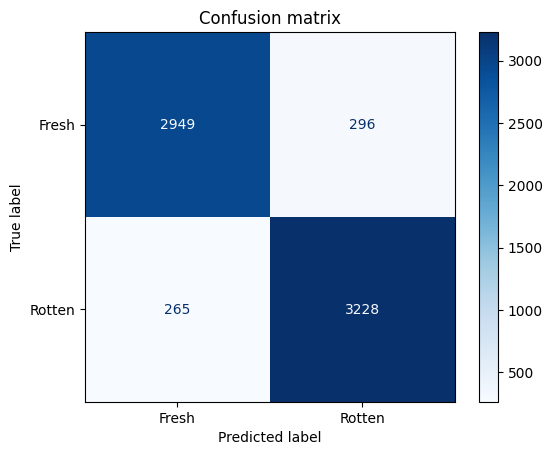

In [11]:
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Fresh", "Rotten"])
disp.plot(cmap="Blues")
plt.title("Confusion matrix")
plt.show()

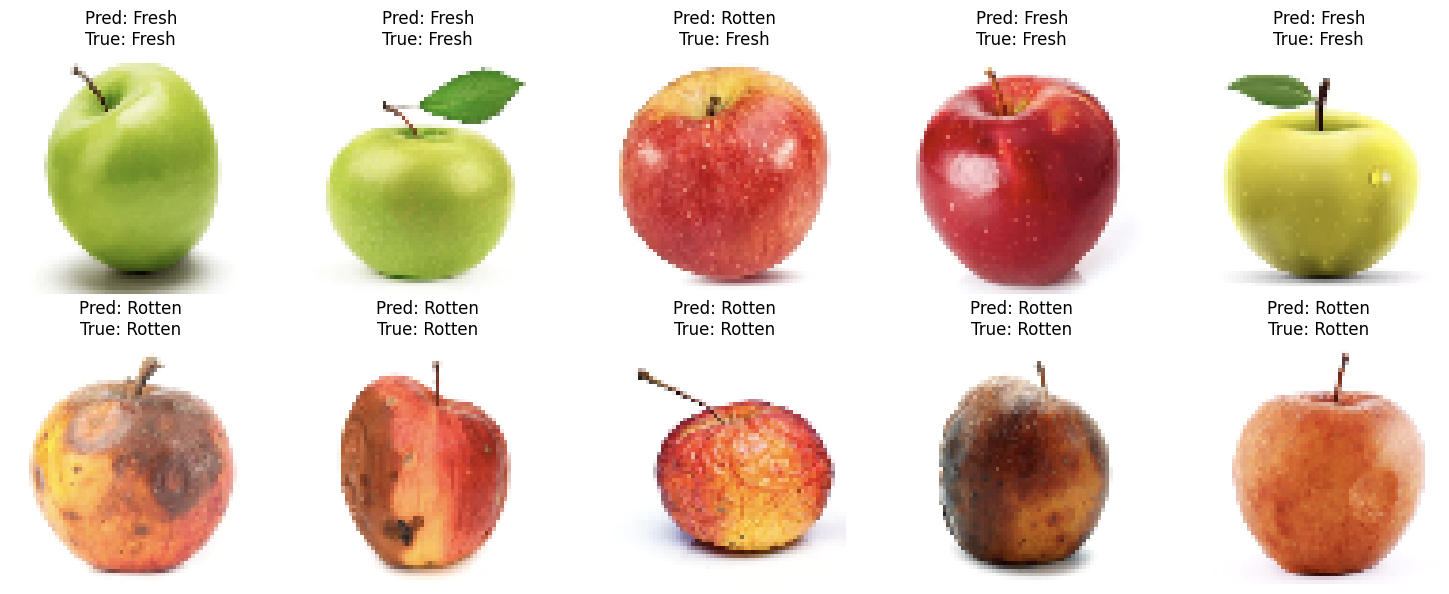

In [12]:
test_data.reset()
samples_shown = {"Fresh": 0, "Rotten": 0}
max_per_class = 5

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()
i = 0

while i < 10:
    images, labels = next(test_data)
    preds = model.predict(images, verbose=0)
    pred_labels = (preds > 0.5).astype(int).flatten()

    for img, true_lbl, pred_lbl in zip(images, labels, pred_labels):
        true_name = "Fresh" if true_lbl == 0 else "Rotten"
        pred_name = "Fresh" if pred_lbl == 0 else "Rotten"

        if samples_shown[true_name] < max_per_class:
            axes[i].imshow(img)
            axes[i].set_title(f"Pred: {pred_name}\nTrue: {true_name}")
            axes[i].axis("off")
            samples_shown[true_name] += 1
            i += 1
            if i >= 10:
                break

plt.tight_layout()
plt.show()